In [2]:
import pandas as pd
import requests
import time
import hvplot.pandas
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import linregress
from scipy import stats
from pathlib import Path
from amadeus import Client, ResponseError
from datetime import datetime, timedelta

from config import amadeus_api
from config import amadeus_sec

In [3]:
#Obtain Amedius token
amadeus = Client(client_id=amadeus_api, client_secret=amadeus_sec)


In [4]:

#To fetch flight offers from Amadeus API for a particular day and save to csv file.

# Define origin and destination cities and their IATA codes
origin_city = 'Sydney'
origin_code = 'SYD'
destination_city = 'Los Angeles'
destination_code = 'LAX'
try:
    
    response = amadeus.shopping.flight_offers_search.get(
        originLocationCode=origin_code,
        destinationLocationCode=destination_code,
        departureDate='2024-11-01',
        adults=1
    )

    # Check if the response contains any flight offers
    if response.data:
        # Extract relevant flight information
        flight_data = []
        for flight in response.data:
            flight_info = {
                'Origin City': f"{origin_city} ({origin_code})",
                'Destination City': f"{destination_city} ({destination_code})",
                'Airline': flight['validatingAirlineCodes'][0],
                'Price (AUD)': flight['price']['total'],
                'Departure Time': flight['itineraries'][0]['segments'][0]['departure']['at'],
                'Arrival Time': flight['itineraries'][0]['segments'][0]['arrival']['at']
            }
            flight_data.append(flight_info)

        # Create a DataFrame from the flight data
        df = pd.DataFrame(flight_data)

        # Print the first five lines of the DataFrame with headers
        print(df.head().to_string(index=False))

        # Save the DataFrame to a CSV file with dynamic names based on origin and destination
        csv_filename = f'flight_offers_{origin_code}_to_{destination_code}.csv'
        df.to_csv(csv_filename, index=False)
        print(f"Data saved to {csv_filename}")
    else:
        print("No flights available.")

except ResponseError as error:
    print(f"An error occurred: {error}")






 Origin City  Destination City Airline Price (AUD)      Departure Time        Arrival Time
Sydney (SYD) Los Angeles (LAX)      FJ      575.98 2024-11-01T14:00:00 2024-11-01T18:45:00
Sydney (SYD) Los Angeles (LAX)      AC      593.24 2024-11-01T10:20:00 2024-11-01T06:55:00
Sydney (SYD) Los Angeles (LAX)      AC      593.24 2024-11-01T10:20:00 2024-11-01T06:55:00
Sydney (SYD) Los Angeles (LAX)      PR      638.74 2024-11-01T11:10:00 2024-11-01T16:30:00
Sydney (SYD) Los Angeles (LAX)      PR      638.74 2024-11-01T11:10:00 2024-11-01T16:30:00
Data saved to flight_offers_SYD_to_LAX.csv


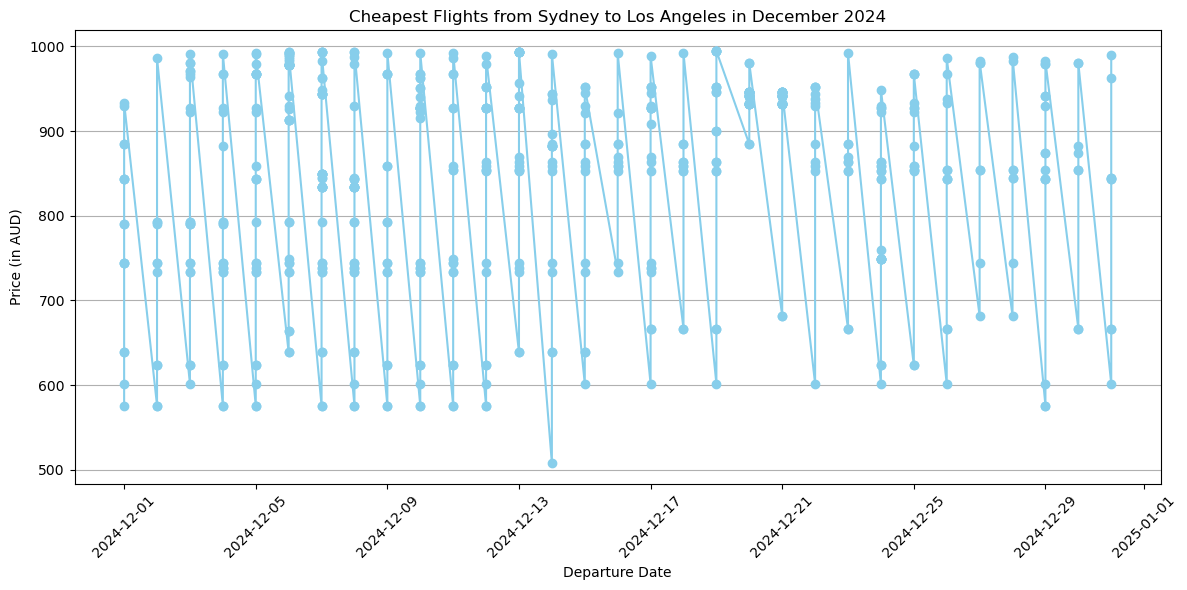

In [5]:
#Filter flight offers from Sydney to Los Angeles for December 2024, within the price range of $500 to $1000.

# Set the month to December
year = 2024
month = 12

# Prepare a list to hold all flight data
all_flights_data = []

# Loop through each day of December
for day in range(1, 32):  
    departure_date = f"{year}-{month:02d}-{day:02d}"

    try:
        # Make a request to the flight offers search endpoint
        response = amadeus.shopping.flight_offers_search.get(
            originLocationCode=origin_code,
            destinationLocationCode=destination_code,
            departureDate=departure_date,
            adults=1
        )

        # Check if there are flight offers for this date
        if response.data:
            for flight in response.data:
                price = float(flight['price']['total'])
                
                # Filter flights within the specified price range
                if 500 <= price <= 1000:
                    flight_info = {
                        'Departure Date': departure_date,
                        'Airline': flight['validatingAirlineCodes'][0],
                        'Price (AUD)': price,
                    }
                    all_flights_data.append(flight_info)

    except ResponseError as error:
        print(f"An error occurred for date {departure_date}: {error}")

# Create a DataFrame from the collected flight data
if all_flights_data:
    df = pd.DataFrame(all_flights_data)
    #save to csv
    df.to_csv('cheapest_flights_december_2024.csv', index=False)

       # Convert 'Departure Date' to datetime for plotting
    df['Departure Date'] = pd.to_datetime(df['Departure Date'])

    # Plotting the line graph
    plt.figure(figsize=(12, 6))
    plt.plot(df['Departure Date'], df['Price (AUD)'], marker='o', linestyle='-', color='skyblue')
    plt.title(f'Cheapest Flights from {origin_city} to {destination_city} in December {year}')
    plt.xlabel('Departure Date')
    plt.ylabel('Price (in AUD)')
    plt.xticks(rotation=45)
    plt.grid(axis='y')

    # Show the plot
    plt.tight_layout()
    plt.savefig('flight_prices_december_2024.png', bbox_inches='tight')  
    plt.show()
    plt.close()  

else:
    print("No flights available for December within the specified price range.")




First five flight offers:
Departure Date Airline  Price (AUD)
    2024-12-01      FJ       575.98
    2024-12-01      MF       601.61
    2024-12-01      PR       638.74
    2024-12-01      PR       638.74
    2024-12-01      NH       743.78
T-statistic: -3.9153, P-value: 0.0001
Reject the null hypothesis: There is a significant difference in flight prices between the first and second halves of December.


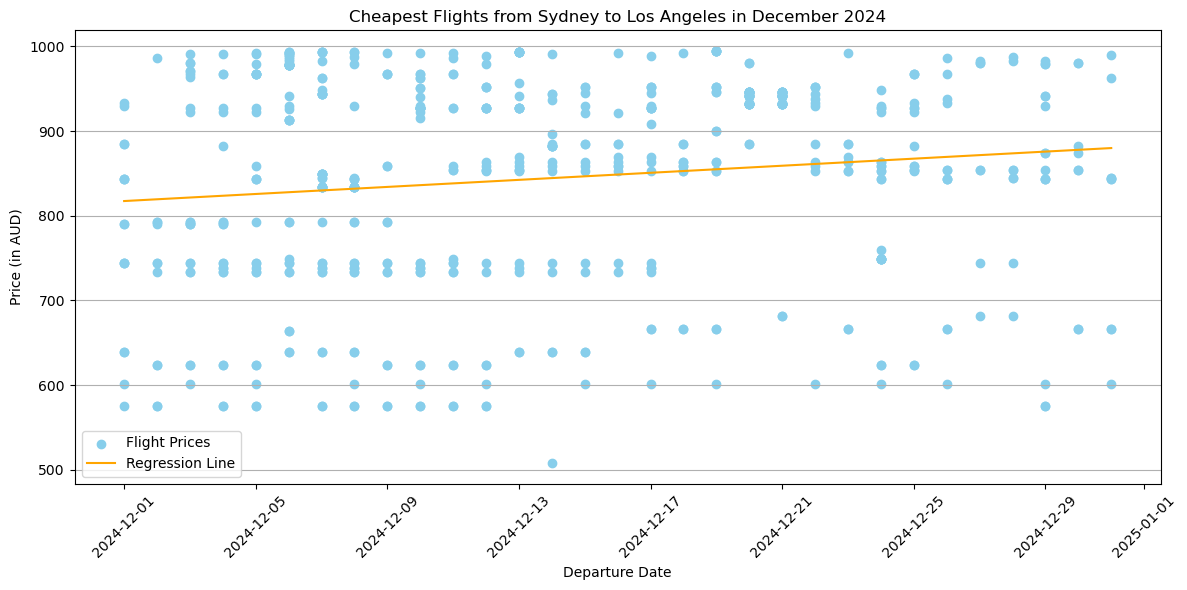

In [6]:
# with linear regression and scatter plot to find cheapest flights from Sydney to Los Angeles
# Create a DataFrame from the collected flight data
#Hypothesis:
#Null Hypothesis (H₀): There is no significant difference in the distribution of flight prices between the first and second halves of December.

#Alternative Hypothesis (H₁): There is a significant difference in the distribution of flight prices between the two periods.

if all_flights_data:
    df = pd.DataFrame(all_flights_data)

    # Print the first five lines of the DataFrame with headers
    print("First five flight offers:")
    print(df.head().to_string(index=False))

    # Convert 'Departure Date' to datetime
    df['Departure Date'] = pd.to_datetime(df['Departure Date'])

    # Separate data into two groups: first half and second half of December
    first_half = df[df['Departure Date'].dt.day <= 15]['Price (AUD)']
    second_half = df[df['Departure Date'].dt.day > 15]['Price (AUD)']

    # Perform a t-test to compare means of flight prices between the two periods
    t_stat, p_value = stats.ttest_ind(first_half, second_half)

    # Print the hypothesis test results
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
    
    # Hypothesis Interpretation
    alpha = 0.05  # Significance level
    if p_value < alpha:
        print("Reject the null hypothesis: There is a significant difference in flight prices between the first and second halves of December.")
    else:
        print("Fail to reject the null hypothesis: No significant difference in flight prices between the two periods.")

    # Linear regression: Add constant for intercept
    X = df['Departure Date'].map(datetime.toordinal)  
    y = df['Price (AUD)']
    X_with_const = sm.add_constant(X)

    # regression model
    model = sm.OLS(y, X_with_const).fit()

    # Plot the flight prices and regression line
    plt.figure(figsize=(12, 6))
    plt.scatter(df['Departure Date'], df['Price (AUD)'], color='skyblue', label='Flight Prices')
    plt.plot(df['Departure Date'], model.predict(X_with_const), color='orange', label='Regression Line')
    plt.title(f'Cheapest Flights from {origin_city} to {destination_city} in December {year}')
    plt.xlabel('Departure Date')
    plt.ylabel('Price (in AUD)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(axis='y')

    # Show the plot
    plt.tight_layout()
    plt.savefig('Linear_regression_Dec24.png', bbox_inches='tight')  
    plt.show()
    plt.close()
else:
    print("No flights available for December within the specified price range.")


Find the Busiest month of the year and average travellers during that period.

In [7]:
#Below is the code to get access token and find the busiest month of the year and average travllers using Amadeus API

# Authenticate with Amadeus API to get the access token
def get_access_token(client_id, client_secret):
    auth_url = "https://test.api.amadeus.com/v1/security/oauth2/token"
    
    headers = {
        'Content-Type': 'application/x-www-form-urlencoded'
    }
    
    data = {
        'grant_type': 'client_credentials',
        'client_id': client_id,
        'client_secret': client_secret
    }

    # Send a POST request to get the access token
    response = requests.post(auth_url, headers=headers, data=data)
    
    if response.status_code == 200:
        return response.json()['access_token']
    else:
        raise Exception(f"Failed to authenticate: {response.status_code}, {response.text}")

# Example credentials (replace with your real credentials)
client_id ="EAH40auAc5FsTbWydLzKIATRmFc0ApuF"
client_secret = "96Ax78gQXWqrDNEf"

try:
    access_token = get_access_token(client_id, client_secret)
    print(f"Access Token: {access_token}")
except Exception as e:
    print(f"Error: {e}")


Access Token: dVuMPAXH0uCK1ABObADqkQ6bGsiG


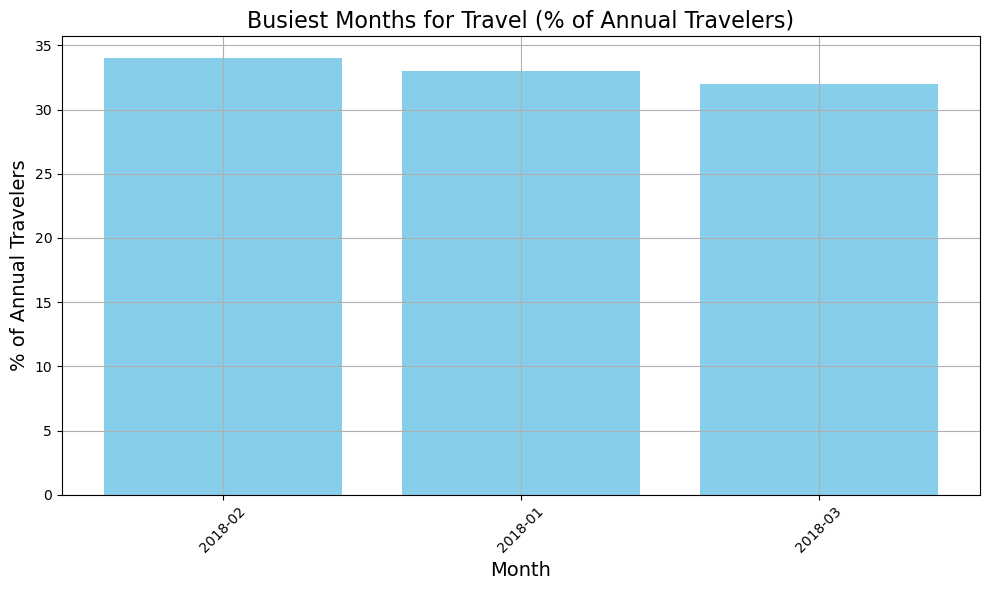

In [9]:


# Call the Flight Busiest Period API for a specific city
def get_busiest_traveling_period(access_token, city_code, year, direction='ARRIVING'):
    url = "https://test.api.amadeus.com/v1/travel/analytics/air-traffic/busiest-period"
    
    headers = {
        'Authorization': f'Bearer {access_token}'
    }
    
    params = {
        'cityCode': city_code, 
        'period': year,         
        'direction': direction  
    }
    
    response = requests.get(url, headers=headers, params=params)
    
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"API request failed: {response.status_code}, {response.text}")

# Analyze the data and store the monthly percentages
def extract_monthly_data(data):
    months = []
    travelers_scores = []
    
    # Loop through the data and collect the month and travelers percentage
    for period in data['data']:
        month = period['period']  
        travelers_score = period['analytics']['travelers']['score']
        
        months.append(month)
        travelers_scores.append(travelers_score)
    
    return months, travelers_scores

#  Plot the busiest months as a bar chart
def plot_busiest_months(months, travelers_scores):
    plt.figure(figsize=(10,6))
    plt.bar(months, travelers_scores, color='skyblue')
    
    plt.title('Busiest Months for Travel (% of Annual Travelers)', fontsize=16)
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('% of Annual Travelers', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('Busiest_Months_Of_travel.png', bbox_inches='tight')  
    plt.show()
    plt.close()

# Main script execution
if __name__ == "__main__":
    
    access_token = 'dVuMPAXH0uCK1ABObADqkQ6bGsiG'

    # Example parameters
    city_code = 'LAX'  
    year = '2018'      
    direction = 'ARRIVING'  
    
#  Call the Busiest Period API
    try:
        data = get_busiest_traveling_period(access_token, city_code, year, direction)
        
        # Step 6: Extract the monthly data
        months, travelers_scores = extract_monthly_data(data)
        
        # Step 7: Plot the busiest months
        plot_busiest_months(months, travelers_scores)
        
    except Exception as e:
        print(f"Error: {e}")
